### Building and Validating Simple Stock Trading Algorithms Using Python

https://www.analyticsvidhya.com/blog/2023/10/building-and-validating-simple-stock-trading-algorithms-using-python/#:~:text=The%20process%20of%20algorithmic%20trading,build%20simple%20stock%20trading%20algorithms.

In [10]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt
from datetime import timedelta as delta
import numpy as np
import os
import seaborn as sb

In [2]:
def get_stock_info(stock, save_to_disk=False):
    start_date = "2000-01-01"
    end_date = (dt.now() + delta(1)).strftime("%Y-%m-%d")
    df = yf.download(f"{stock}.NS", period="1d", start=start_date, end=end_date, progress=False)
    if save_to_disk == True:
        path = "./csv"
        try:
            os.mkdir(path)
        except OSError as error:
            pass
        df.to_csv(f"{path}/{stock}.csv")

    return df


df = get_stock_info("WIPRO", save_to_disk=True)

In [3]:
def add_signal_indicators(df):
    df["SMA_10"] = ta.sma(df["Adj Close"], length=10)
    df["SMA_30"] = ta.sma(df["Adj Close"], length=30)
    df["SMA_50"] = ta.sma(df["Adj Close"], length=50)
    df["SMA_200"] = ta.sma(df["Adj Close"], length=200)

    macd = ta.macd(df["Adj Close"], fast=12, slow=26, signal=9)
    df["MACD"] = macd["MACD_12_26_9"]
    df["MACD_signal"] = macd["MACDs_12_26_9"]
    df["MACD_hist"] = macd["MACDh_12_26_9"]

    df["10_cross_30"] = np.where(df["SMA_10"] > df["SMA_30"], 1, 0)

    df["MACD_Signal_MACD"] = np.where(df["MACD_signal"] < df["MACD"], 1, 0)

    df["MACD_lim"] = np.where(df["MACD"] > 0, 1, 0)

    df["abv_50"] = np.where((df["SMA_30"] > df["SMA_50"]) & (df["SMA_10"] > df["SMA_50"]), 1, 0)

    df["abv_200"] = np.where((df["SMA_30"] > df["SMA_200"]) & (df["SMA_10"] > df["SMA_200"]) & (df["SMA_50"] > df["SMA_200"]), 1, 0)

    return df


df = add_signal_indicators(df)

In [5]:
def calculate_returns(df):
    df["5D_returns"] = (df["Adj Close"].shift(-5) - df["Adj Close"]) / df["Close"] * 100
    df["10D_returns"] = (df["Adj Close"].shift(-10) - df["Adj Close"]) / df["Close"] * 100

    df["5D_positive"] = np.where(df["5D_returns"] > 0, 1, 0)
    df["10D_positive"] = np.where(df["10D_returns"] > 0, 1, 0)

    return df.dropna()


df = calculate_returns(df)

In [6]:
def get_eda_and_deepdive(df):
    eda = df.dropna().groupby(["10_cross_30", "MACD_Signal_MACD", "MACD_lim", "abv_50", "abv_200"])[["5D_returns", "10D_returns"]].agg(["count", "mean", "median", "min", "max"])

    deepdive = (
        df.dropna()
        .groupby(["10_cross_30", "MACD_Signal_MACD", "MACD_lim", "abv_50", "abv_200", "5D_positive", "10D_positive"])[["5D_returns", "10D_returns"]]
        .agg(["count", "mean", "median", "min", "max"])
    )

    return eda, deepdive


eda, deepdive = get_eda_and_deepdive(df)

In [11]:
eda

5D_returns            \
                                                          count      mean   
10_cross_30 MACD_Signal_MACD MACD_lim abv_50 abv_200                        
0           0                0        0      0              724 -0.350048   
                                             1              456  0.246370   
                                      1      0               61 -0.822203   
                                             1              116 -0.683823   
                             1        0      1                7  4.407202   
                                      1      0               17 -4.955867   
                                             1              167  0.246517   
            1                0        0      0              699  0.191050   
                                             1              212  0.195321   
                                      1      0                3  5.628511   
                             1        0      0               23  0.248003   
                                             1               44  1.458515   
                                      1      0               13  4.393416   
                                             1               49  0.994264   
1           0                0        0      0               34 -0.417869   
                                             1               32  1.901455   
                                      1      0               16  0.520326   
                                             1               21 -1.968605   
                             1        0      0               21  2.007653   
                                             1               36  1.508871   
                                      1      0              308  0.440604   
                                             1              840  0.674186   
            1                0        0      0              150  1.065676   
                                             1               45 -0.402727   
                                      1      0                7  2.689186   
                                             1                1 -8.349265   
                             1        0      0              352  0.880589   
                                             1              200  0.510057   
                                      1      0              446  0.641764   
                                             1              777 -0.277017   

                                                                           \
                                                        median        min   
10_cross_30 MACD_Signal_MACD MACD_lim abv_50 abv_200                        
0           0                0        0      0        0.041212 -24.707159   
                                             1        0.613079 -10.966260   
                                      1      0       -0.434454 -24.436409   
                                             1       -0.126638 -16.617741   
                             1        0      1        1.288061  -3.054714   
                                      1      0       -4.330808 -27.201836   
                                             1        0.489857 -14.519616   
            1                0        0      0        0.209116 -25.722769   
                                             1       -0.212780 -10.495056   
                                      1      0        4.282689   2.713967   
                             1        0      0        0.153853  -6.426587   
                                             1        1.966599 -10.092277   
                                      1      0        1.177752  -1.542436   
                                             1        1.081944  -7.539733   
1           0                0        0      0       -0.898487 -10.311402   
                                             1        2.183194  -3.844467   
                                      1      0  

In [12]:
deepdive

5D_returns  \
                                                                                   count   
10_cross_30 MACD_Signal_MACD MACD_lim abv_50 abv_200 5D_positive 10D_positive              
0           0                0        0      0       0           0                   269   
                                                                 1                    86   
                                                     1           0                    91   
                                                                 1                   278   
                                             1       0           0                   148   
...                                                                                  ...   
1           1                1        1      0       1           1                   178   
                                             1       0           0                   297   
                                                                 1                   112   
                                                     1           0                    85   
                                                                 1                   283   

                                                                                         \
                                                                                   mean   
10_cross_30 MACD_Signal_MACD MACD_lim abv_50 abv_200 5D_positive 10D_positive             
0           0                0        0      0       0           0            -5.171869   
                                                                 1            -1.966958   
                                                     1           0             1.673122   
                                                                 1             4.153606   
                                             1       0           0            -3.640705   
...                                                                                 ...   
1           1                1        1      0       1           1             4.442431   
                                             1       0           0            -3.404380   
                                                                 1            -1.639271   
                                                     1           0             1.509046   
                                                                 1             3.007731   

                                                                                         \
                                                                                 median   
10_cross_30 MACD_Signal_MACD MACD_lim abv_50 abv_200 5D_positive 10D_positive             
0           0                0        0      0       0           0            -3.698673   
                                                                 1            -1.298632   
                                                     1           0             1.222553   
                                                                 1             2.625970   
                                             1       0           0            -3.213414   
...                                                                                 ...   
1           1                1        1      0       1           1             3.015535   
                                             1       0           0            -3.111612   
                                                                 1            -1.355838   
                                                     1           0             1.147881   
                                                                 1             2.539732   

                                                                                          \
                                                                                     min   
10_cross_30 MACD_Signal_MACD MACD_lim abv_50 abv_200 5D

In [7]:
x = df.copy()


def _fun(x):
    code = ""
    for i in x.keys():
        code += str(x[i])
    return code


x["signal"] = x[["10_cross_30", "MACD_Signal_MACD", "MACD_lim", "abv_50", "abv_200", "5D_positive", "10D_positive"]].apply(_fun, axis=1)

x = x.dropna()

lim = x.groupby(["10_cross_30", "MACD_Signal_MACD", "MACD_lim", "abv_50", "abv_200", "5D_positive", "10D_positive"])["5D_returns"].agg(["mean"]).reset_index()
lim = lim.sort_values(by="mean", ascending=False).head(10)

x = x.merge(lim, on=["10_cross_30", "MACD_Signal_MACD", "MACD_lim", "abv_50", "abv_200", "5D_positive", "10D_positive"], how="inner")

/tmp/ipykernel_25861/2586695197.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


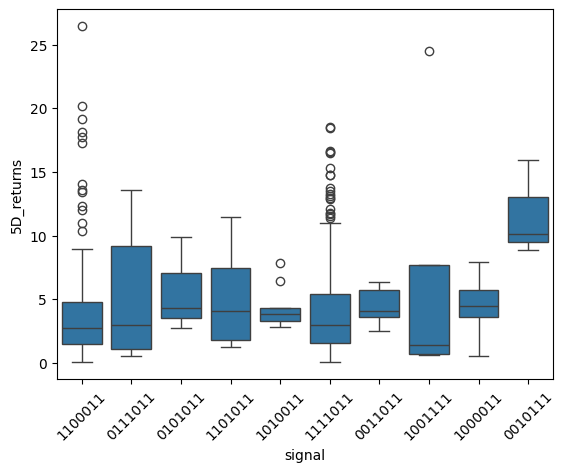

In [8]:
ax = sb.boxplot(x="signal", y="5D_returns", data=x)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

/tmp/ipykernel_25861/589222353.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


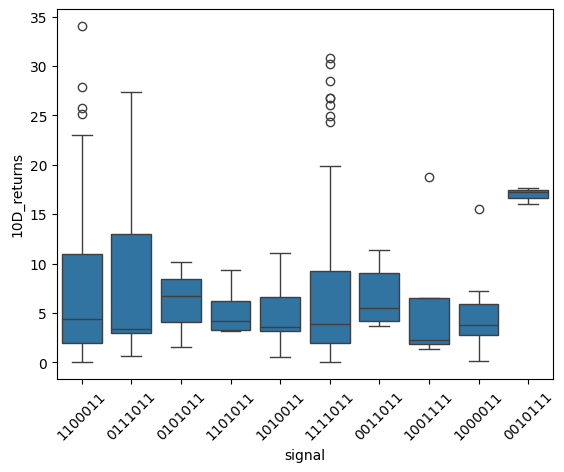

In [9]:
ax = sb.boxplot(x="signal", y="10D_returns", data=x)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()